In [20]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

# Extre libraries
from datetime import datetime

/kaggle/input/online-retail-ii-uci/online_retail_II.csv


In [21]:
os.listdir('/kaggle/input/online-retail-ii-uci')

['online_retail_II.csv']

In [22]:
data = pd.read_csv('/kaggle/input/online-retail-ii-uci/online_retail_II.csv')

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [23]:
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


# Creating necessary columns

In [24]:
# Making sure Date is in datetime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Total ammount column
data['TotalAmount'] = data['Price'] * data['Quantity']

data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# Dropping null columns

In [25]:
# Validating null values
data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
TotalAmount         0
dtype: int64

In [26]:
# Validating negative values
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price              5
Quantity       22950
TotalAmount    19498
dtype: int64

In [27]:
# Deleting all rows with null values
data = data.dropna(subset = ['Customer ID'])

# Eliminating rows with negative quantities

# Note: don't eliminate this data, TO BE DETERMINED

data = data[data['Quantity'] >= 0]

data = data[data['Price'] >= 0]

In [28]:
# Validating null values again
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalAmount    0
dtype: int64

In [29]:
# Validating negative values again
(data[['Price', 'Quantity', 'TotalAmount']] < 0).sum()

Price          0
Quantity       0
TotalAmount    0
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

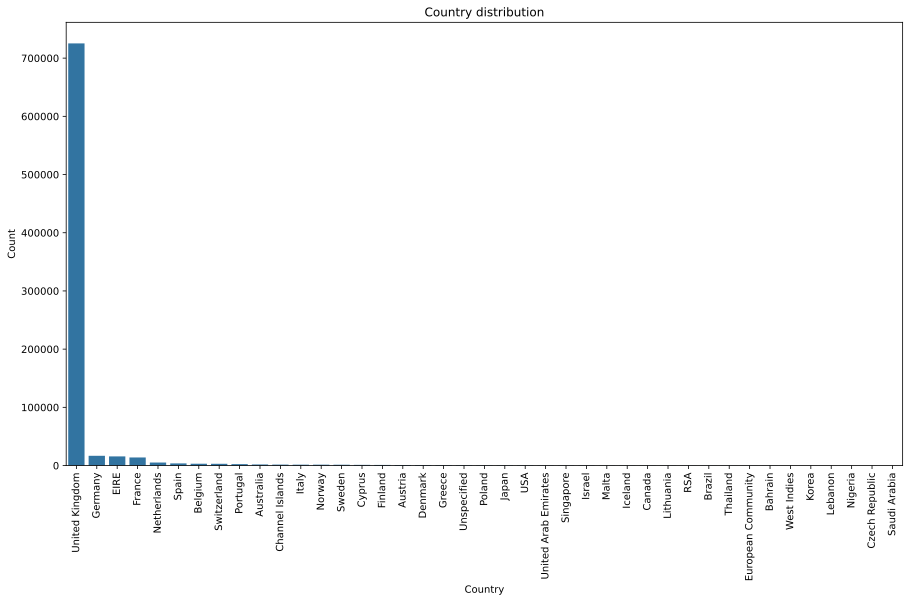

In [30]:
# Country distribution
plt.figure(figsize=(15, 8))
sns.countplot(data= data, x='Country', order=data['Country'].value_counts().index)
plt.title('Country distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation= 90)
plt.show

In [31]:
# We'll only work with transactions from the UK

# Keeping only transactions made in the UK
data = data[data['Country'] == 'United Kingdom']

In [32]:
print(data['Country'].describe())

count             725296
unique                 1
top       United Kingdom
freq              725296
Name: Country, dtype: object


# Price, Quantity and Total Amount distributions

In [33]:
# Distribution for Quantity
print(data['Quantity'].describe())

count    725296.000000
mean         12.021055
std         141.560253
min           1.000000
25%           2.000000
50%           4.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64


In [34]:
# Distribution for Price
print(data['Price'].describe())

count    725296.000000
mean          3.056583
std          25.164725
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       10953.500000
Name: Price, dtype: float64


In [35]:
# Distribution for TotalAmount
print(data['TotalAmount'].describe())

count    725296.000000
mean         20.299502
std         233.938767
min           0.000000
25%           4.200000
50%          10.200000
75%          17.700000
max      168469.600000
Name: TotalAmount, dtype: float64


# Data division between present and future

In [36]:
futureMax = data['InvoiceDate'].max()

print(futureMax)

2011-12-09 12:49:00


In [37]:
# Data delimitation (three months before)
presentvalue = pd.Timestamp('2011-09-01')

print(presentvalue)

2011-09-01 00:00:00


In [38]:
# Dividing data between present and future
futureData = data[(data['InvoiceDate'] > presentvalue) & (data['InvoiceDate'] <= presentvalue + pd.DateOffset(months=3))]

data = data[data['InvoiceDate'] <= presentvalue]

In [39]:
data.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 571315 entries, 0 to 846153
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      571315 non-null  object        
 1   StockCode    571315 non-null  object        
 2   Description  571315 non-null  object        
 3   Quantity     571315 non-null  int64         
 4   InvoiceDate  571315 non-null  datetime64[ns]
 5   Price        571315 non-null  float64       
 6   Customer ID  571315 non-null  float64       
 7   Country      571315 non-null  object        
 8   TotalAmount  571315 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 43.6+ MB


In [41]:
futureData.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
846166,565080,20677,PINK POLKADOT BOWL,8,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,10.0
846167,565080,22128,PARTY CONES CANDY ASSORTED,24,2011-09-01 08:25:00,1.25,13509.0,United Kingdom,30.0
846169,565082,22423,REGENCY CAKESTAND 3 TIER,2,2011-09-01 09:15:00,12.75,13305.0,United Kingdom,25.5
846170,565082,15060B,FAIRY CAKE DESIGN UMBRELLA,8,2011-09-01 09:15:00,3.75,13305.0,United Kingdom,30.0
846171,565082,23245,SET OF 3 REGENCY CAKE TINS,4,2011-09-01 09:15:00,4.95,13305.0,United Kingdom,19.8


In [42]:
futureData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138180 entries, 846166 to 1041829
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      138180 non-null  object        
 1   StockCode    138180 non-null  object        
 2   Description  138180 non-null  object        
 3   Quantity     138180 non-null  int64         
 4   InvoiceDate  138180 non-null  datetime64[ns]
 5   Price        138180 non-null  float64       
 6   Customer ID  138180 non-null  float64       
 7   Country      138180 non-null  object        
 8   TotalAmount  138180 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 10.5+ MB
